In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


In [2]:
df_train = pd.read_excel('data/raw/тест.xls', sheet_name='Обучающая')
df_validation = pd.read_excel('data/raw/тест.xls', sheet_name='Тестовая')
df_all = pd.concat([df_train, df_validation])
df_all_cut = df_all[df_all.columns[1:-3]]

In [3]:
df_all_cut.info()
# пропусков нет

<class 'pandas.core.frame.DataFrame'>
Index: 9048 entries, 0 to 3037
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ВОЗРАСТ                      9048 non-null   float64
 1   ВОЗРАСТ.ЛЕТ                  9048 non-null   int64  
 2   ПОЛ                          9048 non-null   int64  
 3   СМЕНА_МЖ                     9048 non-null   int64  
 4   ЗАГРАН                       9048 non-null   int64  
 5   БРАК                         9048 non-null   int64  
 6   ДЕТИ                         9048 non-null   int64  
 7   ИЖДИВЕНЦЫ                    9048 non-null   int64  
 8   ОБРАЗОВАНИЕ                  9048 non-null   int64  
 9   ИНОСТР.ЯЗЫК                  9048 non-null   int64  
 10  АВТО                         9048 non-null   int64  
 11  ОТРАСЛЬ                      9048 non-null   int64  
 12  РАБОТА_ПО_НАПР               9048 non-null   int64  
 13  РАБОТА_В_ОРГ           

Присутствуют категориальные переменные, их убираем.

In [4]:
categorical = ['ПОЛ', 'ОБРАЗОВАНИЕ', 'ОТРАСЛЬ', 'РАБОТА_ПО_НАПР', 'РАБОТА_В_ОРГ', 'ДОЛЖНОСТЬ', 'ОТДЕЛЕНИЕ', 'ГОРОД']
df_train = df_train.drop(categorical, axis=1)
df_validation = df_validation.drop(categorical, axis=1)

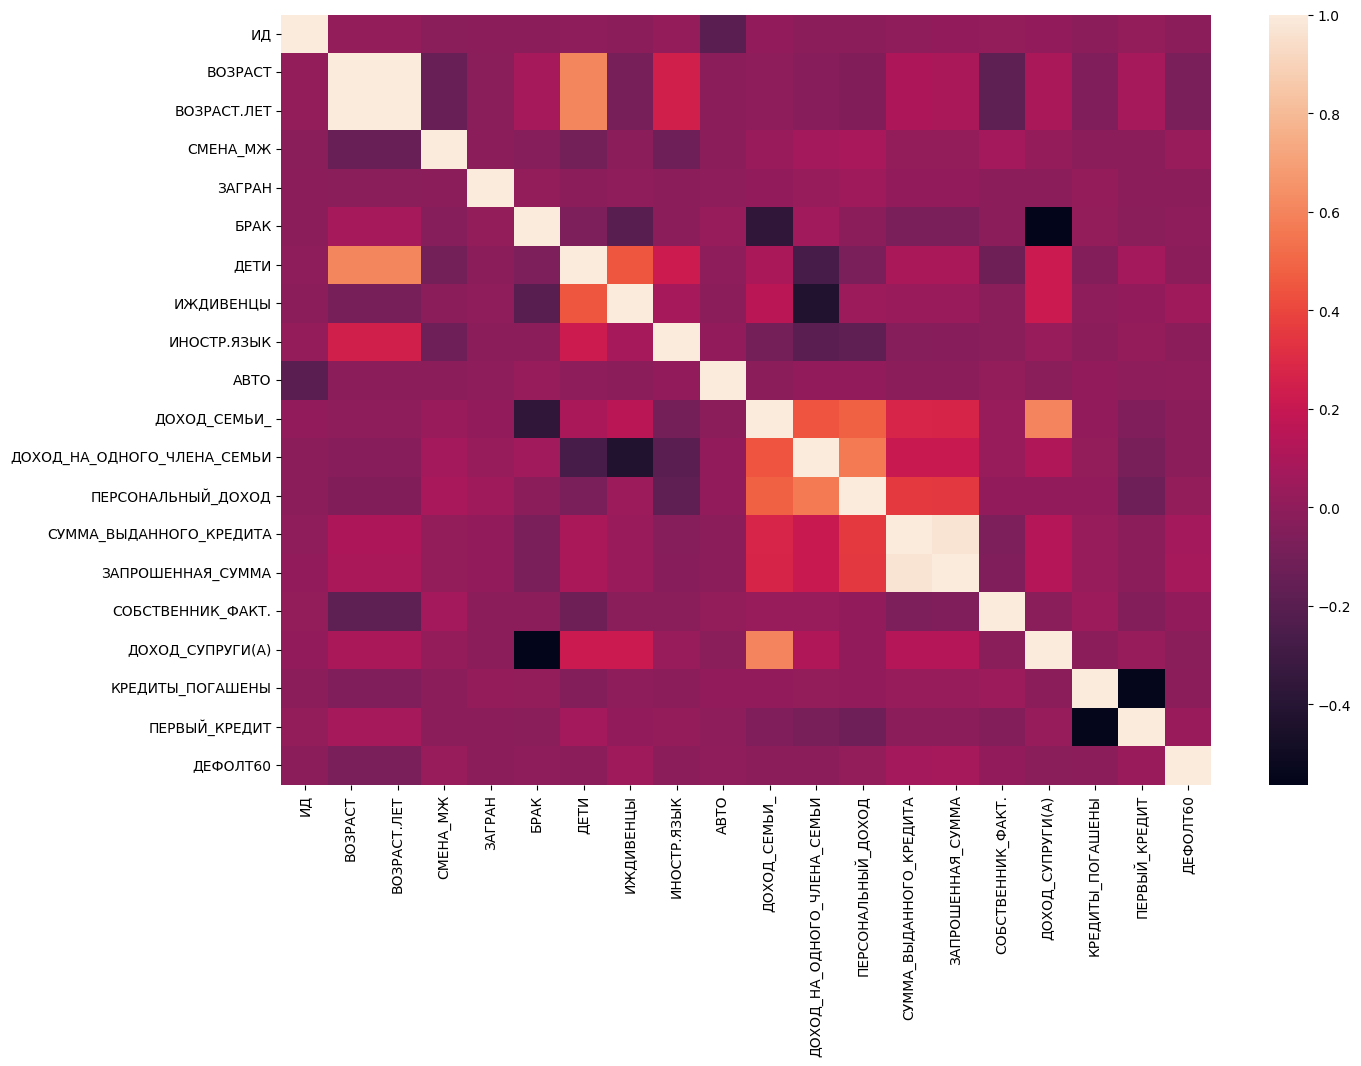

In [5]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df_train.corr())
plt.show()

Есть мультиколлинеарность и категориальные переменные.
- Возраст (коррелирует с Возраст.лет)
- Дети (коррелируют с возрастом)
- Брак (коррелирует с доходом супруги)
- Сумма выданного кредита (коррелирует с запрошенной суммой)
- Доход супруга (с доходом семьи)
- Доход семьи (с доходом на 1 члена семьи)
- Кредиты погашены (с ПЕРВЫЙ_КРЕДИТ)
- Иждивенцы (с доходом на 1 члена семьи)
- Персональный доход (с доходом на 1 члена семьи)
- Авто (в валидационной у всех нули)

In [6]:
df_train.columns

Index(['ИД', 'ВОЗРАСТ', 'ВОЗРАСТ.ЛЕТ', 'СМЕНА_МЖ', 'ЗАГРАН', 'БРАК', 'ДЕТИ',
       'ИЖДИВЕНЦЫ', 'ИНОСТР.ЯЗЫК', 'АВТО', 'ДОХОД_СЕМЬИ_',
       'ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ', 'ПЕРСОНАЛЬНЫЙ_ДОХОД',
       'СУММА_ВЫДАННОГО_КРЕДИТА', 'ЗАПРОШЕННАЯ_СУММА', 'СОБСТВЕННИК_ФАКТ.',
       'ДОХОД_СУПРУГИ(А)', 'КРЕДИТЫ_ПОГАШЕНЫ', 'ПЕРВЫЙ_КРЕДИТ', 'ДЕФОЛТ60'],
      dtype='object')

In [7]:
# для удобства графического представления кластеров берем три основные переменные.
columns_of_interest_train =  ['ВОЗРАСТ.ЛЕТ', 'ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ', 'СУММА_ВЫДАННОГО_КРЕДИТА', 'ДЕФОЛТ60']
columns_of_interest_validation =  ['ВОЗРАСТ.ЛЕТ', 'ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ', 'СУММА_ВЫДАННОГО_КРЕДИТА']

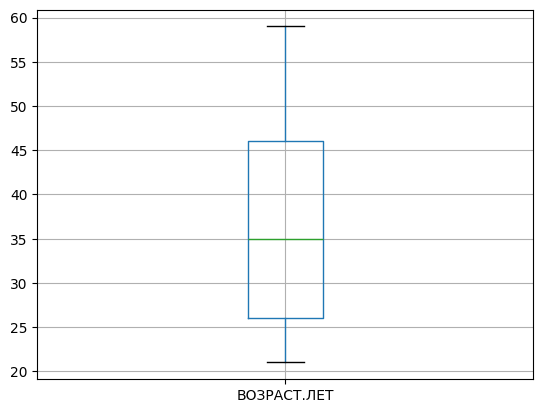

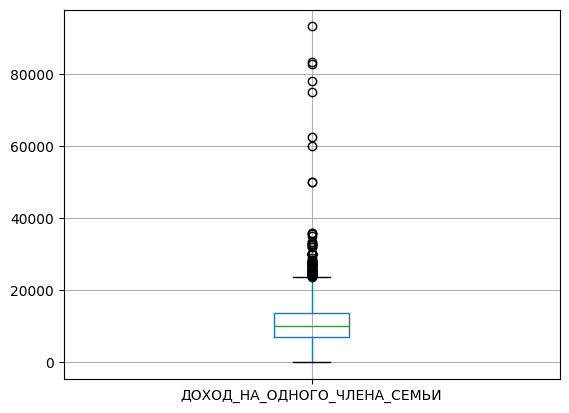

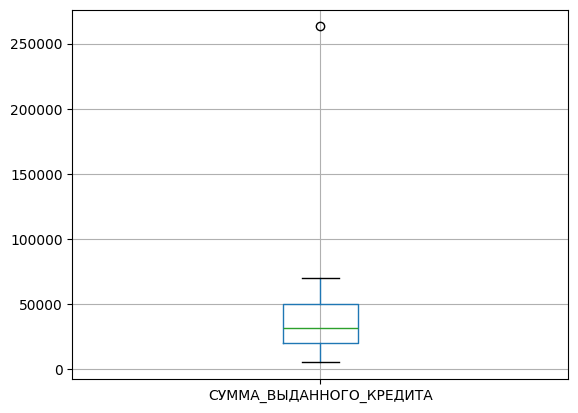

In [8]:
for column in columns_of_interest_train[:-1]:

    df_train.boxplot(column=column)
    plt.show()

In [244]:
# в дальнейшем от удаления выбросов отказалась, так как негативно влияло на метрики.
for column in columns_of_interest_train[:-1]:
  median = df_train[column].median()
  q1 = df_train[column].quantile(q=.25)
  q3 = df_train[column].quantile(q=.75)
  iqr = df_train[column].apply(stats.iqr)
  outliers_mask = ((df_train[column] < (q1 - 1.5 * iqr)) | (df_train[column] > (q3 + 1.5 * iqr)))
  df_train.loc[outliers_mask, column] = median

In [9]:
df_train[columns_of_interest_train].describe()

ВОЗРАСТ.ЛЕТ  ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ  СУММА_ВЫДАННОГО_КРЕДИТА  \
count  6010.000000                  6010.000000              6010.000000   
mean     36.372879                 10906.830727             36322.930666   
std      10.729161                  5783.961152             20077.587493   
min      21.000000                     0.000000              5000.000000   
25%      26.000000                  7000.000000             20000.000000   
50%      35.000000                 10000.000000             31500.000000   
75%      46.000000                 13667.000000             50000.000000   
max      59.000000                 93333.000000            263175.000000   

          ДЕФОЛТ60  
count  6010.000000  
mean      0.201997  
std       0.401523  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [10]:
df_train = df_train[columns_of_interest_train]
df_validation = df_validation[columns_of_interest_validation]

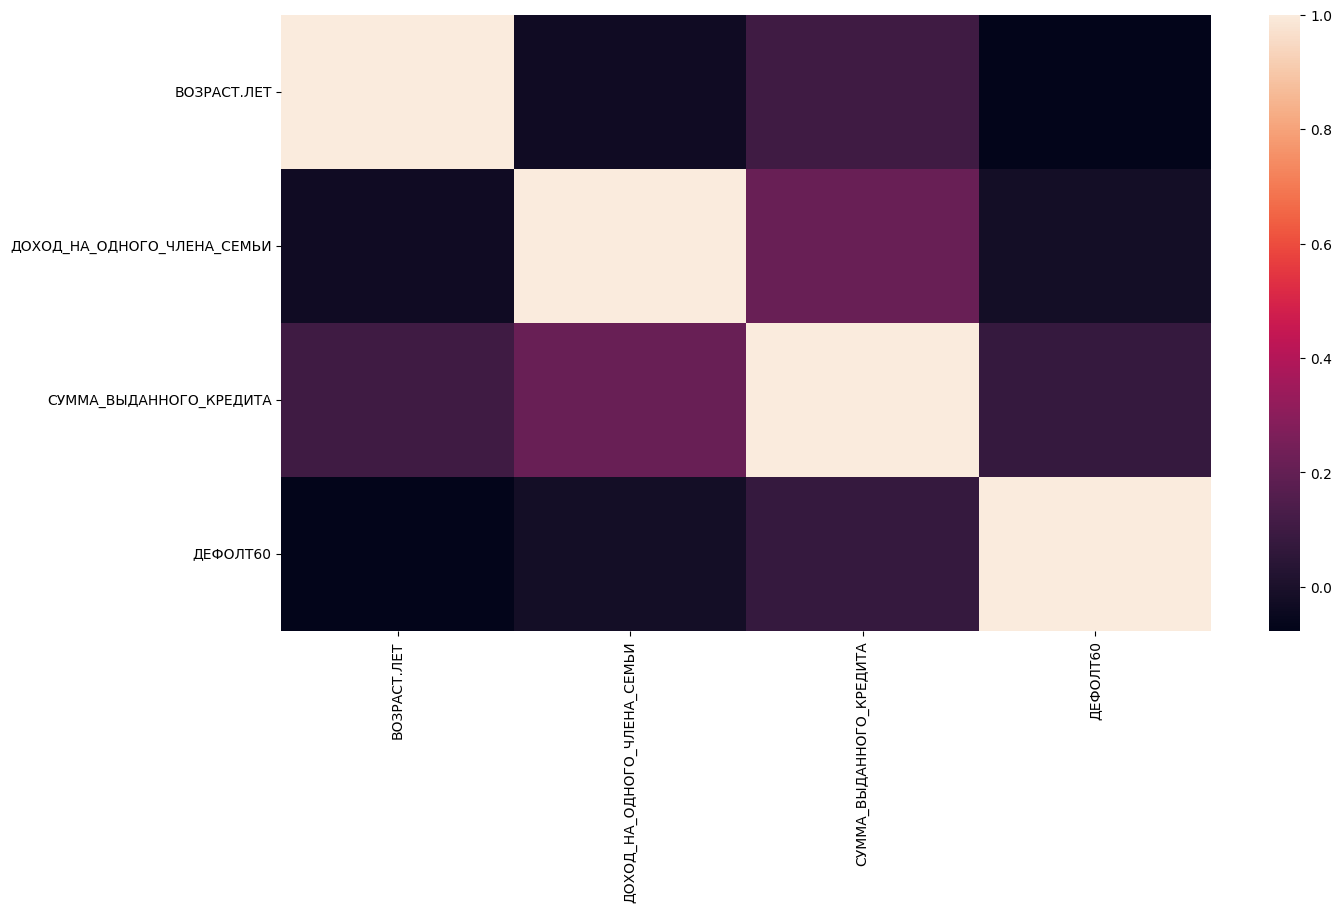

In [11]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(df_train.corr())
plt.show()
# прямых зависимостей между переменными и таргетом нет.

In [11]:
scaler = MinMaxScaler()
df_train[columns_of_interest_train[:-1]] = scaler.fit_transform(df_train[columns_of_interest_train[:-1]])
df_validation[columns_of_interest_validation] = scaler.fit_transform(df_validation[columns_of_interest_validation])

In [12]:
# кластеризация KMeans
# определение количества кластеров
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_train[columns_of_interest_train[:-1]])
    wcss.append(kmeans.inertia_)

d:\Обучение\sberleasing\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Обучение\sberleasing\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Обучение\sberleasing\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
d:\Обучение\sberleasing\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

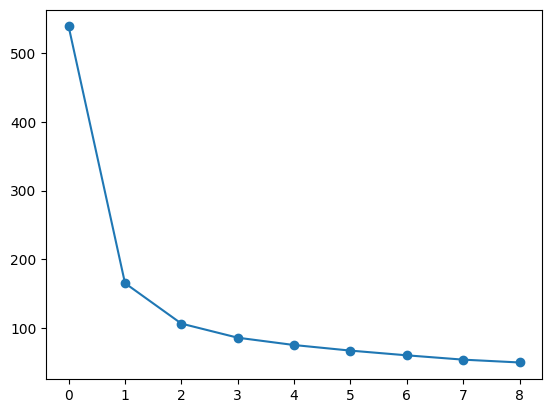

In [13]:
plt.plot(wcss, marker='o')

Преломление на 3 кластерах

In [14]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(df_train[columns_of_interest_train[:-1]])

d:\Обучение\sberleasing\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [15]:
df_train['cluster'] = kmeans.predict(df_train[columns_of_interest_train[:-1]])

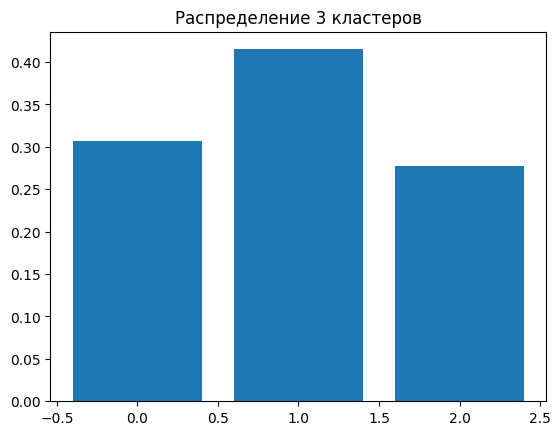

[41.49750416 30.71547421 27.78702163]


In [16]:
plt.bar(df_train['cluster'].value_counts(normalize=True).index, df_train['cluster'].value_counts(normalize=True).values)
plt.title('Распределение 3 кластеров')
plt.show()
print(df_train['cluster'].value_counts(normalize=True).values * 100)

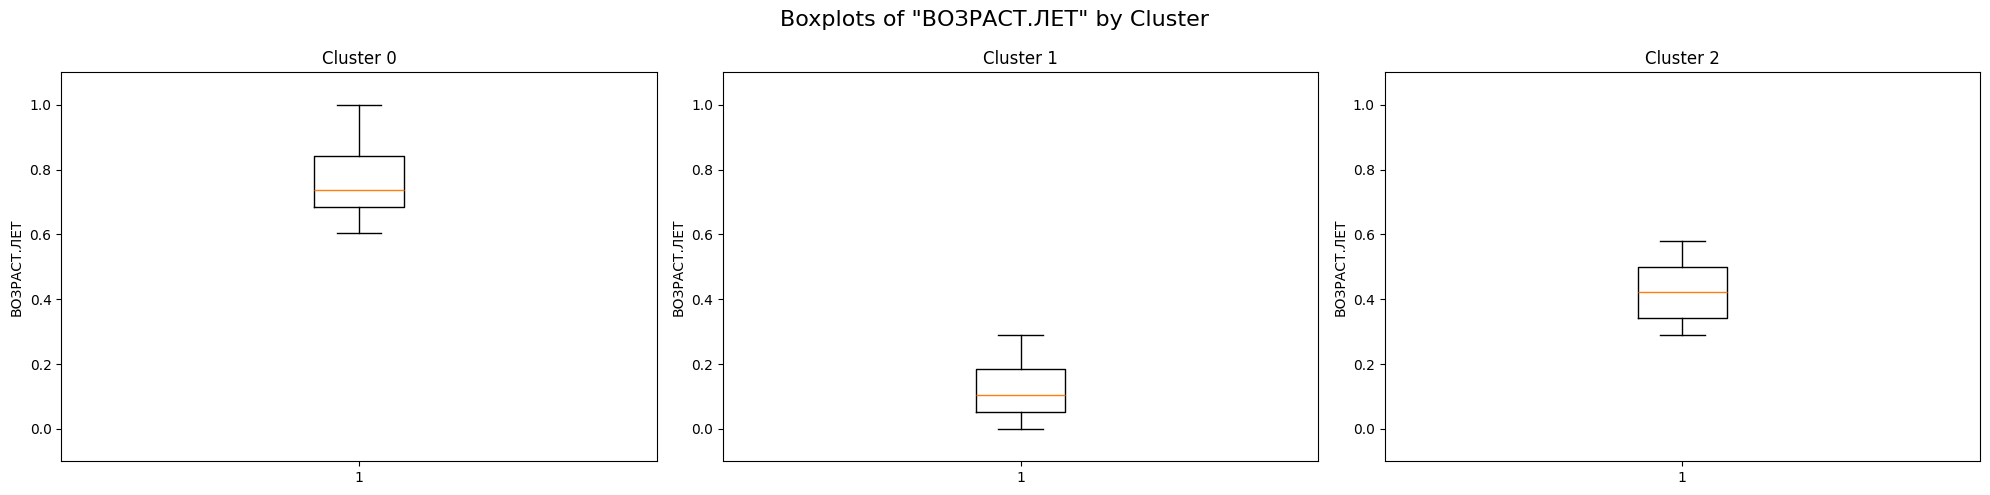

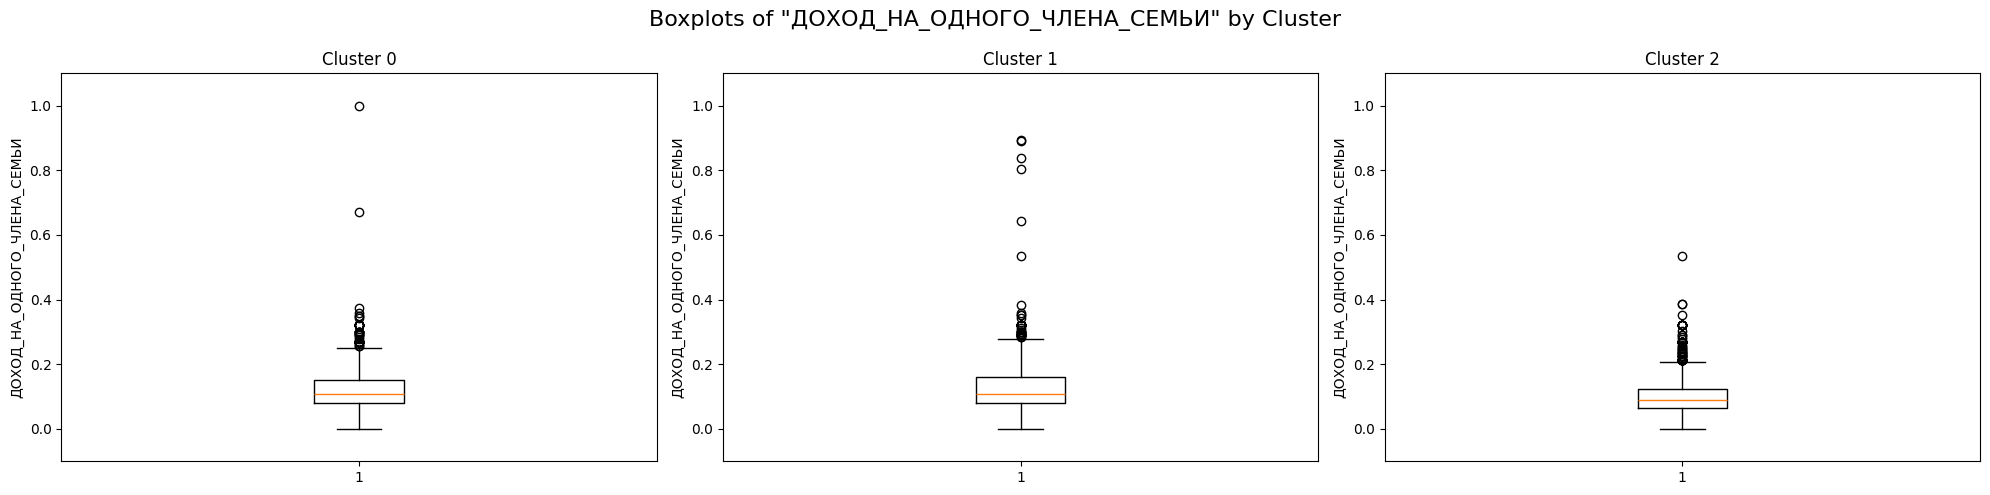

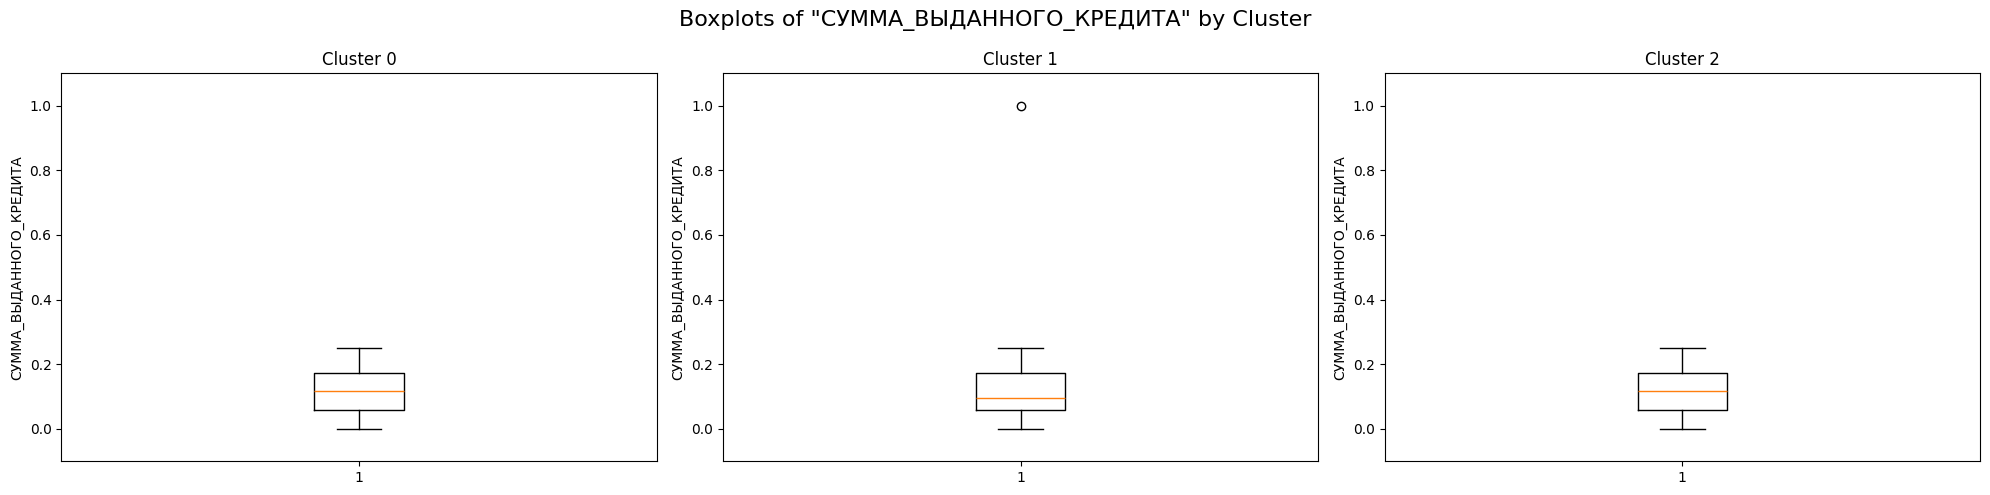

In [17]:
for column in columns_of_interest_train[:-1]:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

    for i in range(3):
        axes[i].boxplot(df_train[df_train['cluster'] == i][column])
        axes[i].set_title('Cluster {}'.format(i))
        axes[i].set_ylim(-0.1, 1.1)
        axes[i].set_ylabel(column)

    plt.suptitle(f'Boxplots of "{column}" by Cluster', fontsize=16)

    plt.tight_layout()

    plt.show()

In [18]:
# 3d визуализация
fig = px.scatter_3d(df_train,
                    x=columns_of_interest_train[0], y=columns_of_interest_train[1], z=columns_of_interest_train[2],
                    color='cluster',
                    title=f'3d visualization for 6 clusters of {columns_of_interest_train[0]},  {columns_of_interest_train[1]},  {columns_of_interest_train[2]}',
                    width=1000, height=1000)
fig.show()

In [19]:
for cluster in sorted(df_train['cluster'].unique()):
    print(cluster)
    print(pd.DataFrame(scaler.inverse_transform(df_train[df_train['cluster'] == cluster][columns_of_interest_train[:-1]]),
                                                columns=columns_of_interest_train[:-1]).describe())

0
       ВОЗРАСТ.ЛЕТ  ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ  СУММА_ВЫДАННОГО_КРЕДИТА
count   1846.00000                  1846.000000              1846.000000
mean      49.85428                 10166.335833             13324.491208
std        3.94019                  5043.476403              5063.681882
min       44.00000                     0.000000              5000.000000
25%       47.00000                  6696.425702              8776.508182
50%       49.00000                  8928.567602             12553.016365
75%       53.00000                 12499.994643             16329.524547
max       59.00000                 83333.000000             21364.868791
1
       ВОЗРАСТ.ЛЕТ  ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ  СУММА_ВЫДАННОГО_КРЕДИТА
count  2494.000000                  2494.000000              2494.000000
mean     25.690457                 10348.586111             12210.412936
std       2.906142                  5546.731106              4940.739027
min      21.000000                     0.000000

Кластеры поделились по возрасту:
- пожилые
- молодые
- среднего возраста

In [20]:
X = df_train[df_train.columns[:-2]]
y = df_train['ДЕФОЛТ60']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
y.value_counts()
# Дисбаланс классов

ДЕФОЛТ60
0    4796
1    1214
Name: count, dtype: int64

In [22]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1202
           1       0.40      0.01      0.01       301

    accuracy                           0.80      1503
   macro avg       0.60      0.50      0.45      1503
weighted avg       0.72      0.80      0.71      1503



In [23]:
model = SVC(probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1202
           1       0.00      0.00      0.00       301

    accuracy                           0.80      1503
   macro avg       0.40      0.50      0.44      1503
weighted avg       0.64      0.80      0.71      1503



d:\Обучение\sberleasing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Обучение\sberleasing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Обучение\sberleasing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [24]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# Наилучший из трех моделей результат по первому классу

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1202
           1       0.21      0.19      0.20       301

    accuracy                           0.69      1503
   macro avg       0.50      0.50      0.50      1503
weighted avg       0.68      0.69      0.69      1503



In [25]:
# oversample
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

In [26]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1206
           1       1.00      0.95      0.97      1192

    accuracy                           0.97      2398
   macro avg       0.97      0.97      0.97      2398
weighted avg       0.97      0.97      0.97      2398



In [27]:
df_validation['ДЕФОЛТ60 (Прогноз)'] = model.predict(df_validation)

In [28]:
df_validation[['proba_0', 'proba_1']] = model.predict_proba(df_validation[columns_of_interest_validation])

In [29]:
df_validation[columns_of_interest_validation] = scaler.inverse_transform(df_validation[columns_of_interest_validation])

In [30]:
df_validation

ВОЗРАСТ.ЛЕТ  ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ  СУММА_ВЫДАННОГО_КРЕДИТА  \
0            35.0                       7500.0                  20000.0   
1            34.0                       3750.0                  15000.0   
2            36.0                       5000.0                  30000.0   
3            26.0                       9300.0                  20000.0   
4            44.0                       5733.0                  13000.0   
...           ...                          ...                      ...   
3033         32.0                       5000.0                  70000.0   
3034         23.0                       6666.0                   6000.0   
3035         28.0                       3250.0                  55000.0   
3036         46.0                      15000.0                  70000.0   
3037         26.0                       8500.0                  40000.0   

      ДЕФОЛТ60 (Прогноз)  proba_0  proba_1  
0                      0      1.0      0.0  
1                      1      0.0      1.0  
2                      1      0.0      1.0  
3                      0      1.0      0.0  
4                      1      0.0      1.0  
...                  ...      ...      ...  
3033                   1      0.0      1.0  
3034                   1      0.0      1.0  
3035                   0      1.0      0.0  
3036                   0      1.0      0.0  
3037                   0      1.0      0.0  

[3038 rows x 6 columns]

In [31]:
df_validation.to_excel('data/processed/Тестовая.xlsx')

Этапы:

1) Получение заявки    
В заявке указывается возраст заемщика, количество членов семьи, совокупный доход семьи, желаемая сумма кредита.  
2) Скоринг  
Рассчитывается доход на одного члена семьи.  
В модель подаются три переменные: возраст, доход на одного члена семьи и желаемая сумма кредита. Данные масштабируются и на выход подается 0 в случае, если низкая вероятность просрочки, и 1, если высокая. Таким образом отсеиваются наиболее неблагонадежные заемщики.
3) Андеррайтинг  
Анализ дополнительных факторов, не используемых в модели, согласно политики банка.  
4) Верификация  
Проверка данных, предоставленных пользователем: проверка паспортных данных, получение справки о составе семьи и справки о доходах.  
5) Проверка в Бюро Кредитных Историй  
Запрос информации о заемщике + о членах семьи в Бюро Кредитных Историй.  
6) Проверка по Черным Спискам  
Проверка заемщика + членов семьи
7) Принятие финального решения о выдаче или отказе в выдачи кредита  
8) Отправка решения клиенту